# Лабораторная работа №5.
## Клименко Виталий Б01-203
### Лаба по уравнениям в частных производных:

(must have) 1. Задачка из парпроги - предъявить численное решение уравнения переноса и сравнить его с аналитическим (постановку аналитической задачи найти самостоятельно): 
 - использовать схемы для численного решения: уголок, прямоугольник, Лакс-Вендрофф (Явная четырехточечная схема)
- провести исследование на сходимость (сравнение численного и аналитического решения)
- провести анализ порядка аппроксимации (сходимости) (график с убыванием нормы ошибки в зависимости от шага интегрирования в логарифмическом масштабе).

### Аналитическая задача, которая решается 3-мя методами:

$$
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0, \quad
u(x, 0) = \sin(2\pi x), \quad
u(0, t) = \sin(2\pi(0 - at))
$$

### Её решение

$$
u(x, t) = \sin\left(2\pi(x - at)\right),
$$


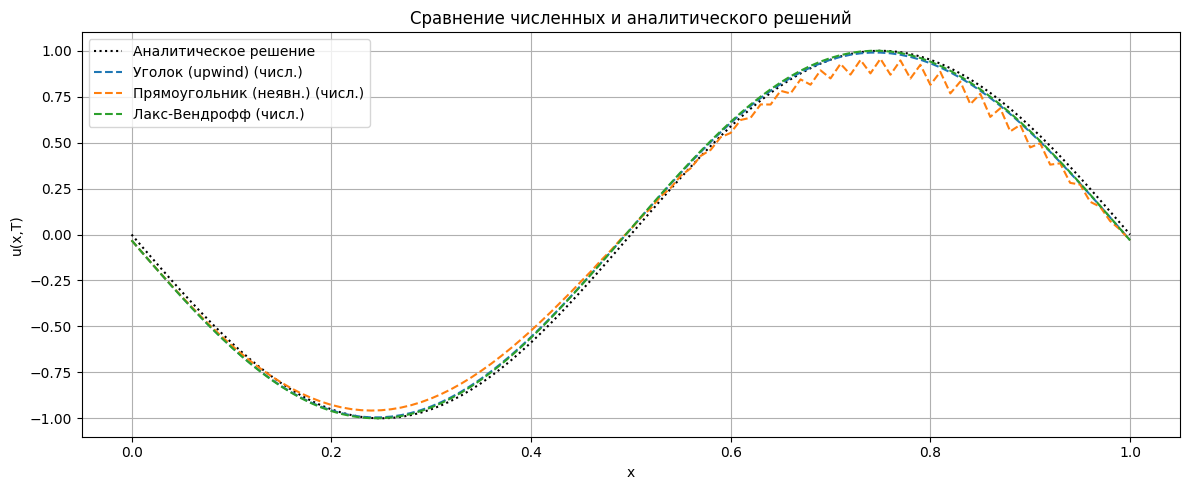

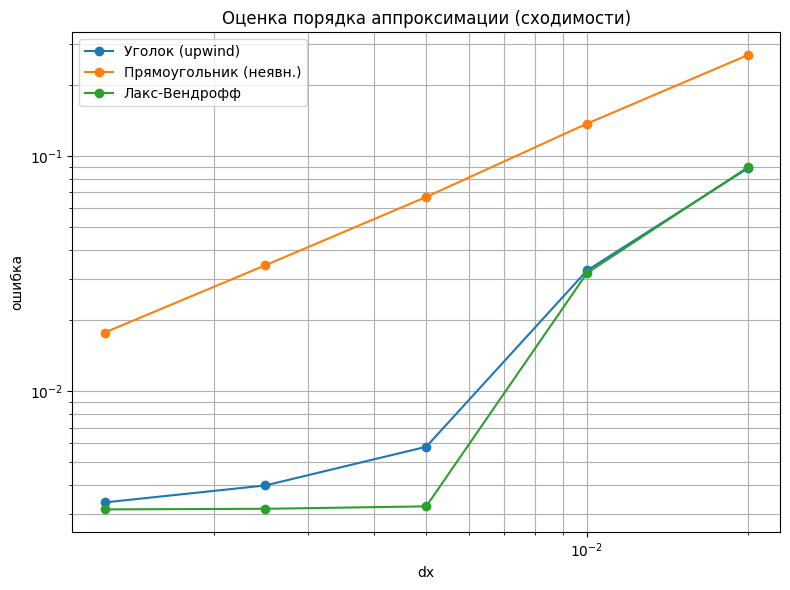

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# зафиксирую параметры задачи
a = 1.0       
L = 1.0         
T = 0.5         

# аналитическое решение
u0_func = lambda x: np.sin(2 * np.pi * x)
u_exact = lambda x, t: np.sin(2 * np.pi * (x - a * t))

# угол
def upwind(N, CFL):
    dx = L / N
    dt = CFL * dx / a
    M = int(T / dt)
    x = np.linspace(0, L, N + 1)
    u = u0_func(x)
    for n in range(M):
        u[1:] = u[1:] - CFL * (u[1:] - u[:-1])
        u[0] = u_exact(0, (n+1)*dt)
    return x, u, dx

# лакс–вендрофф
def lax_wendroff(N, CFL):
    dx = L / N
    dt = CFL * dx / a
    M = int(T / dt)
    x = np.linspace(0, L, N + 1)
    u = u0_func(x)
    for n in range(M):
        u_new = u.copy()
        u_new[1:-1] = u[1:-1] - 0.5 * CFL * (u[2:] - u[:-2]) + \
                      0.5 * CFL**2 * (u[2:] - 2*u[1:-1] + u[:-2])
        u_new[0] = u_exact(0, (n+1)*dt)
        u_new[-1] = u_exact(1, (n+1)*dt)
        u = u_new
    return x, u, dx

# неявная схема "прямоугольник"
def rectangle_implicit(N, CFL):
    dx = L / N
    dt = CFL * dx / a
    M = int(T / dt)
    x = np.linspace(0, L, N + 1)
    u = u0_func(x)

    alpha = a * dt / (2 * dx)

    lower = -alpha * np.ones(N - 2)
    center = np.ones(N - 1)
    upper = alpha * np.ones(N - 2)

    ab = np.zeros((3, N - 1))
    ab[0, 1:] = upper
    ab[1, :]  = center
    ab[2, :-1] = lower

    for n in range(M):
        rhs = u[1:-1].copy()
        rhs[0]  += alpha * u_exact(0, (n+1)*dt)
        rhs[-1] -= alpha * u_exact(1, (n+1)*dt)
        u_inner = solve_banded((1, 1), ab, rhs)
        u[1:-1] = u_inner
        u[0] = u_exact(0, (n+1)*dt)
        u[-1] = u_exact(1, (n+1)*dt)
    return x, u, dx

# построение решений и сравнение
schemes = {
    'Уголок (upwind)': upwind,
    'Прямоугольник (неявн.)': rectangle_implicit,
    'Лакс-Вендрофф': lax_wendroff
}

CFL = 0.9
N = 100
t_final = T

plt.figure(figsize=(12, 5))
x_ref = np.linspace(0, L, N + 1)
u_an = u_exact(x_ref, t_final)
plt.plot(x_ref, u_an, 'k:', label='Аналитическое решение')

for name, method in schemes.items():
    x, u_num, dx = method(N, CFL)
    plt.plot(x, u_num, '--', label=f'{name} (числ.)')

plt.title('Сравнение численных и аналитического решений')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# сходимости
dx_vals = []
err_vals = {name: [] for name in schemes}

for N in [50, 100, 200, 400, 800]:
    for name, method in schemes.items():
        x, u_num, dx = method(N, CFL)
        u_an = u_exact(x, T)
        error = np.linalg.norm(u_an - u_num, ord=np.inf)
        err_vals[name].append(error)
    dx_vals.append(dx)

plt.figure(figsize=(8, 6))
for name in schemes:
    plt.loglog(dx_vals, err_vals[name], label=name, marker='o')
plt.title('Оценка порядка аппроксимации (сходимости)')
plt.xlabel('dx')
plt.ylabel('ошибка')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Заключение

Сравнил с точным решением;

Построил графики решения и ошибки;

Получил логарифмические графики зависимости нормы ошибки от шага сетки.